In [1]:
import pandas as pd
import numpy as np

import gc
import os
import sys

from multiprocessing import Pool

import operator
from collections import Counter

In [2]:
sys.path.insert(0, os.getenv("HOME") + "/workdir/MusicMap/")

from utils.mp3_to_wav import convert_one_audio
from utils.wav_file_wrapper import *

In [3]:
%matplotlib inline

In [4]:
MNT_HDD_PROJECT="/mnt/hdd/music_map_project/"
MNT_SSD_PROJECT="/mnt/ssd/musicmap_data/"

DATA_MP3 = os.path.join(MNT_HDD_PROJECT, "audio")
DATA_WAV = os.path.join(MNT_HDD_PROJECT, "audio_wav")

SPECTRO = os.path.join(MNT_SSD_PROJECT, "audio_spectro")

In [5]:
if not os.path.exists(DATA_WAV):
    os.mkdir(DATA_WAV)
    
if not os.path.exists(SPECTRO):
    os.mkdir(SPECTRO)

In [6]:
for (dirpath, dirnames, filenames) in os.walk(DATA_MP3):
    break

audio_ids = map(lambda x: os.path.splitext(x)[0], filenames)
len(audio_ids)

2802

In [7]:
np.random.seed(8888)

### Convert \*.mp3 to \*.wav

In [ ]:
if len(os.listdir(DATA_WAV)) > 0:
    raise NameError("Directory is not empty!")

try:   
    pool = Pool(processes=10)
    res = pool.map_async(convert_one_audio, zip(
        map(lambda s: s+'.mp3', audio_ids),
        [DATA_MP3] * len(audio_ids),
        [DATA_WAV] * len(audio_ids)
    ))
    res.get()
finally:
    pool.terminate()
    pool.join()

### Inspect audios length

In [ ]:
audio_lengths = dict()

for i, audio in enumerate(audio_ids):
    wav_file = WavFile.read(os.path.join(DATA_WAV, audio+'.wav'))
    audio_lengths[audio] = len(wav_file)
    if (i + 1) % 100 == 0:
        print i + 1

In [ ]:
audio_lengths_grouped = sorted(
    list(Counter(audio_lengths.values()).iteritems()),
    key=operator.itemgetter(0)
)
audio_lengths_grouped

In [ ]:
len(filter(lambda x: x[0] > 45, audio_lengths_grouped))

### Bootstrap spectros

In [ ]:
def bootstrap_spectros(audio_id):
    wav_file = WavFile.read(os.path.join(DATA_WAV, audio_id+'.wav'))
    for offset, subsample in bootstrap_track(wav_file, nb_secs=30, size=1):
        save_spectrogram(subsample, os.path.join(
            SPECTRO, "{}_{:04}.png".format(audio_id, offset)
        ), size=(256, 215))
    print audio_id+".png"

In [ ]:
if len(os.listdir(SPECTRO)) > 0:
    raise NameError("Directory is not empty!")

try:
    pool = Pool(processes=15)
    res = pool.map_async(bootstrap_spectros, audio_ids)
    res.wait()
finally:
    pool.terminate()
    pool.join()

### Split by train and test

In [8]:
df = pd.read_csv("/mnt/hdd/music_map_project/balanced_audio_target.csv", index_col=0)
df.head()

,song_filename,valence,arousal
0,7D,5.8,6.4
1,8D,3.2,4.8
2,25D,7.9,4.7
3,31D,4.7,3.8
4,37D,6.6,5.3


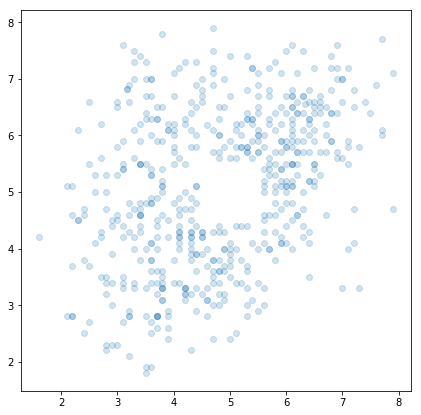

In [21]:
plt.figure(figsize=(7,7))
plt.scatter(df["valence"], df["arousal"], alpha=0.2)

In [10]:
audios_va = dict(zip(df.values[:,0], map(list, list(df.values[:,1:]))))

In [11]:
audio_ids = df["song_filename"].values
np.random.shuffle(audio_ids)

In [12]:
border = int(len(audio_ids) * 0.9)
train_set, valid_set = set(audio_ids[:border]), set(audio_ids[border:])

In [13]:
train_dataset, valid_dataset = [], []

for (dirpath, dirnames, filenames) in os.walk(SPECTRO):
    for spectro_name in filenames:
        audio_id = spectro_name.split('_')[0]
        if audio_id in train_set:
            # audio_va = (np.array(audios_va[audio_id]) + np.random.normal(loc=0, scale=0.02, size=2)).tolist()
            train_dataset.append([spectro_name] + audios_va[audio_id])
        if audio_id in valid_set:
            # audio_va = (np.array(audios_va[audio_id]) + np.random.normal(loc=0, scale=0.02, size=2)).tolist()
            valid_dataset.append([spectro_name] + audios_va[audio_id])

In [14]:
df_train = pd.DataFrame(train_dataset, columns=df.columns)
df_valid = pd.DataFrame(valid_dataset, columns=df.columns)

In [15]:
SPECTRO_CSV = SPECTRO + "_csv"

if not os.path.exists(SPECTRO_CSV):
    os.mkdir(SPECTRO_CSV)

In [16]:
df_train.to_csv(os.path.join(SPECTRO_CSV, "train.csv"), index=False)
df_valid.to_csv(os.path.join(SPECTRO_CSV, "valid.csv"), index=False)

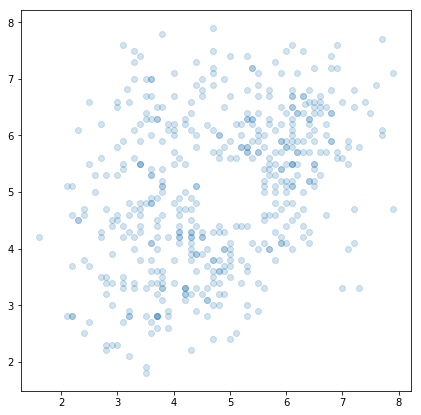

In [17]:
plt.figure(figsize=(7,7))
plt.scatter(df_train["valence"], df_train["arousal"], alpha=0.2)

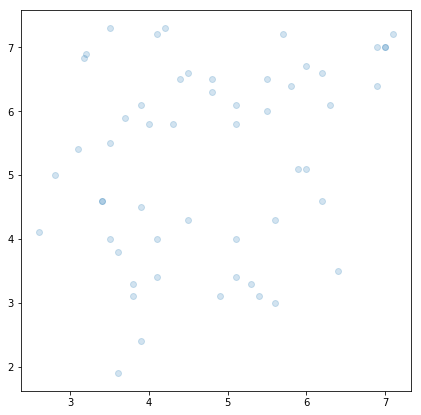

In [18]:
plt.figure(figsize=(7,7))
plt.scatter(df_valid["valence"], df_valid["arousal"], alpha=0.2)

In [20]:
len(df_train) + len(df_valid) == len(df)

True

In [24]:
len(df_train), len(df_valid), len(df)

(481, 54, 535)